# PA KECERDASAN BUATAN
## Pendeteksi Keretakan pada Bangunan
## Kelompok 4
AZIIZAH OKI SHOFRINA (2109106004) <br>
ALIYA IRFANI         (2109106007) <br>
CHINTIA LIU WINTIN   (2109106008) <br>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Data Collecting

## A. Training Set

In [2]:
train_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="binary",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=1,
    subset="training",
    validation_split=0.1,
    batch_size=128
)

Found 36000 files belonging to 2 classes.
Using 32400 files for training.


## B. Validation Set

In [3]:
val_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="binary",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=1,
    subset="validation",
    validation_split=0.1,
    batch_size=128
)

Found 36000 files belonging to 2 classes.
Using 3600 files for validation.


## C. Testing Set

In [4]:
test_set = image_dataset_from_directory(
    "dataset/test",
    labels="inferred",
    label_mode="binary",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=False,
    batch_size=128
)

Found 4000 files belonging to 2 classes.


### Kelas yang Digunakan

In [5]:
classes = train_set.class_names
classes

['Negative', 'Positive']

### Shape Gambar dan Label

In [6]:
for images, labels in train_set.take(1):
    print(images.shape)
    print(labels.shape)
    break

(128, 64, 64, 3)
(128, 1)


## Preview Gambar

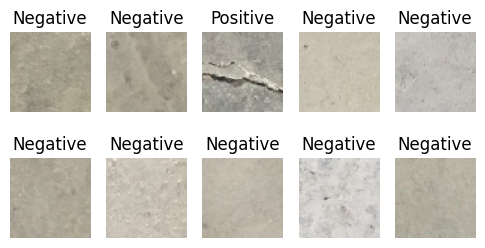

In [7]:
def preview_imgs(dataset):
    plt.figure(figsize=(6, 3))

    # ambil 1 batch
    for images, labels in dataset.take(1):
        
        # ambil 9 gambar
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("Negative" if labels[i].numpy()== 0 else "Positive")
            plt.axis("off")
            
preview_imgs(train_set)

## Sample Gambar

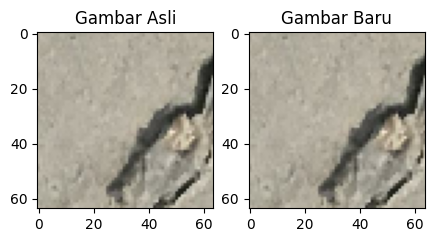

In [8]:
def sample_img(image1, image2):
    plt.figure(figsize=(5, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Gambar Asli")
    plt.imshow(image1.numpy().astype("uint8"))
    
    plt.subplot(1, 2, 2)
    plt.title("Gambar Baru")
    plt.imshow(image2.numpy().astype("uint8"))

# ambil 1 contoh gambar
for images, labels in train_set.take(1):
    ori_img = images[0]

sample_img(ori_img, ori_img)

# 2. Data Preprocessing, Data Analisis, dan Visualisasi

## A. Brightness
Sesuaikan kecerahan gambar

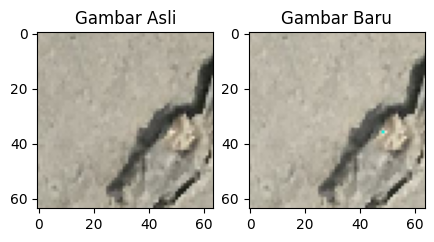

In [9]:
sample_img(ori_img, tf.image.random_brightness(ori_img, max_delta=10, seed=42))

#### Sesuaikan kecerahan dataset gambar

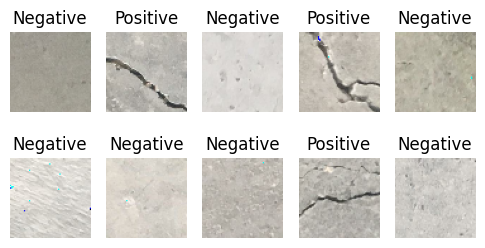

In [10]:
def brightness(x, y):
    image = tf.image.random_brightness(x, max_delta=10, seed=42)
    return image, y

b_train = train_set.map(brightness)
b_val = val_set.map(brightness)
b_test = test_set.map(brightness)

preview_imgs(b_train)

## B. Hue
Memberikan nuansa warna baru pada gambar

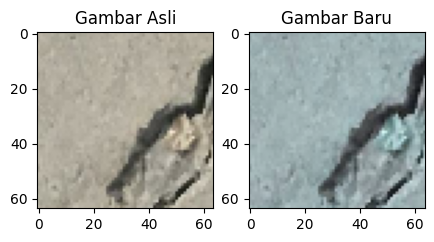

In [11]:
sample_img(ori_img, tf.image.random_hue(ori_img, max_delta=0.5, seed=42))

### Sesuaikan warna dataset gambar

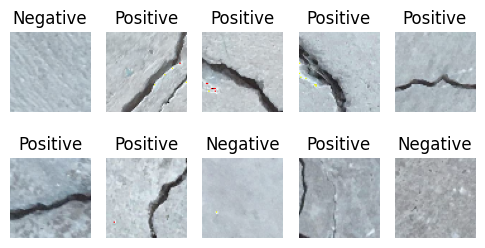

In [12]:
def hue(x, y):
    image = tf.image.random_hue(x, max_delta=0.5, seed=42)
    return image, y
    
hue_train = b_train.map(hue)
hue_val = b_val.map(hue)
hue_test = b_test.map(hue)

preview_imgs(hue_train)

## C. Saturation
Menyesuaikan insensitas warna. Semakin tinggi saturasi, semakin terang

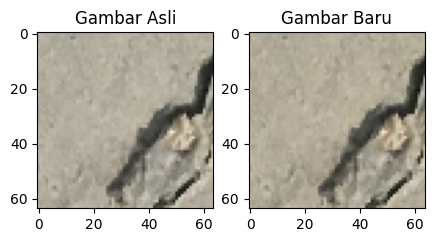

In [13]:
sample_img(ori_img, tf.image.random_saturation(ori_img, 0.5, 1.5, seed=42))

### Sesuaikan saturasi dataset gambar

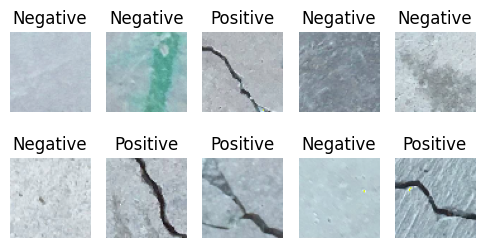

In [14]:
def saturate(x, y):
    image = tf.image.random_saturation(x, 0.5, 1.5, seed=42)
    return image, y
    
s_train = hue_train.map(saturate)
s_val = hue_val.map(saturate)
s_test = hue_test.map(saturate)

preview_imgs(s_train)

## D. Grayscale
Membuat gambar skala abu-abu

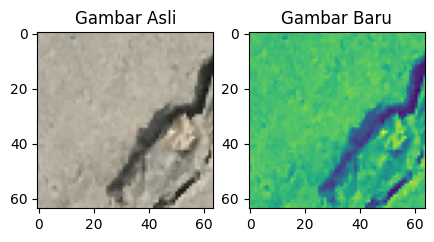

In [15]:
sample_img(ori_img, tf.image.rgb_to_grayscale(ori_img))

### Grayscaling dataset gambar

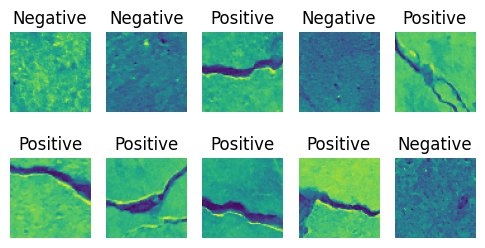

In [16]:
def grayscale(x, y):
    image = tf.image.rgb_to_grayscale(x)
    return image, y

g_train = train_set.map(grayscale)
g_val = val_set.map(grayscale)
g_test = test_set.map(grayscale)

preview_imgs(g_train)

### Shape Gambar Setelah Grayscaling

In [17]:
for image, label in g_train.take(1):
    print(image.numpy().shape)
    break

(128, 64, 64, 1)


## E. Contrast
Meningkatkan perbedaan antara bagian yang lebih cerah dan lebih gelap

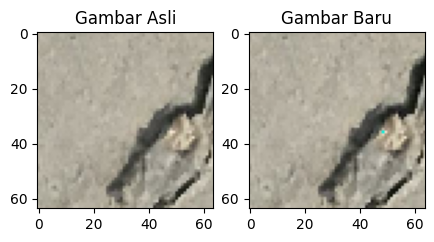

In [18]:
sample_img(ori_img, tf.image.random_contrast(ori_img, 1, 1.5, seed=42))

### Kontraskan dataset gambar RGB

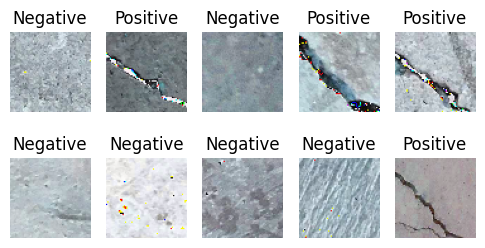

In [19]:
def contrast(x, y):
    image = tf.image.random_contrast(x, 1, 1.5, seed=42)
    return image, y

c_train_rgb = s_train.map(contrast)
c_val_rgb = s_val.map(contrast)
c_test_rgb = s_test.map(contrast)

preview_imgs(c_train_rgb)

### Kontraskan dataset gambar Grayscale

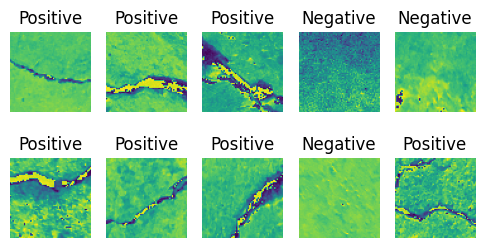

In [20]:
c_train_gray = g_train.map(contrast)
c_val_gray = g_val.map(contrast)
c_test_gray = g_test.map(contrast)

preview_imgs(c_train_gray)

## F. Standardisasi
Standardisasi gambar sehingga memiliki rata-rata 0 dan varians 1

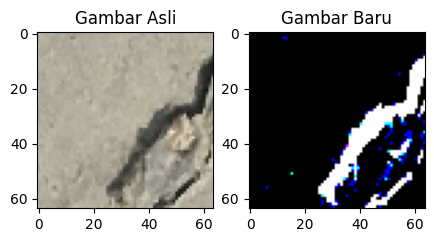

In [21]:
sample_img(ori_img, tf.image.per_image_standardization(ori_img))

### Standardisasi dataset gambar RGB

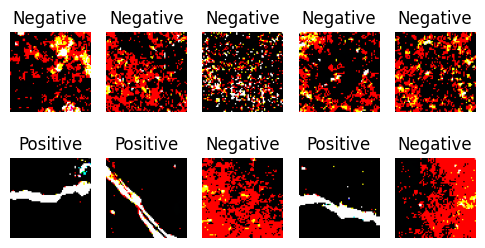

In [22]:
def standardization(x, y):
    image = tf.image.per_image_standardization(x)
    return image, y

std_train_rgb = c_train_rgb.map(standardization)
std_val_rgb = c_val_rgb.map(standardization)
std_test_rgb = c_test_rgb.map(standardization)

preview_imgs(std_train_rgb)

### Standardisasi dataset gambar Grayscale

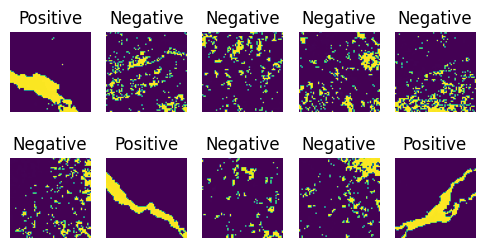

In [23]:
std_train_gray = c_train_gray.map(standardization)
std_val_gray = c_val_gray.map(standardization)
std_test_gray = c_test_gray.map(standardization)

preview_imgs(std_train_gray)

# 3. Data Modelling dan Evaluasi

## A. Model RGB

In [24]:
model_rgb = Sequential([
    Input((64, 64, 3)),
    
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_rgb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [25]:
model_rgb.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model RGB - Fitting Model

In [26]:
history_rgb = model_rgb.fit(
    c_train_rgb,
    validation_data=c_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 87s 334ms/step - loss: 1.2974 - accuracy: 0.9445 - val_loss: 0.0708 - val_accuracy: 0.9828
Epoch 2/10
254/254 [==============================] - 85s 331ms/step - loss: 0.0661 - accuracy: 0.9852 - val_loss: 0.0621 - val_accuracy: 0.9856
Epoch 3/10
254/254 [==============================] - 86s 335ms/step - loss: 0.0468 - accuracy: 0.9891 - val_loss: 0.0512 - val_accuracy: 0.9903
Epoch 4/10
254/254 [==============================] - 86s 337ms/step - loss: 0.0328 - accuracy: 0.9921 - val_loss: 0.0505 - val_accuracy: 0.9883
Epoch 5/10
254/254 [==============================] - 86s 337ms/step - loss: 0.0215 - accuracy: 0.9940 - val_loss: 0.0323 - val_accuracy: 0.9928
Epoch 6/10
254/254 [==============================] - 86s 335ms/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0361 - val_accuracy: 0.9914
Epoch 7/10
254/254 [==============================] - 86s 338ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 0.0268 - val_ac

### Model RGB - Visualisasi Training Validation

In [27]:
def visualisasi_plot(model):
    epoch = [i+1 for i in range(10)]

    sns.set_theme()

    plt.figure(figsize=(14, 7))
    plt.suptitle("Train vs Validation")

    # grafik akurasi
    plt.subplot(1, 2, 1)
    plt.title("Akurasi")
    sns.lineplot(
        x=epoch,
        y=model.history["accuracy"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_accuracy"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Akurasi(%)")

    # grafik loss
    plt.subplot(1, 2, 2)
    plt.title("Loss")
    sns.lineplot(
        x=epoch,
        y=model.history["loss"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_loss"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(%)")

    plt.show()

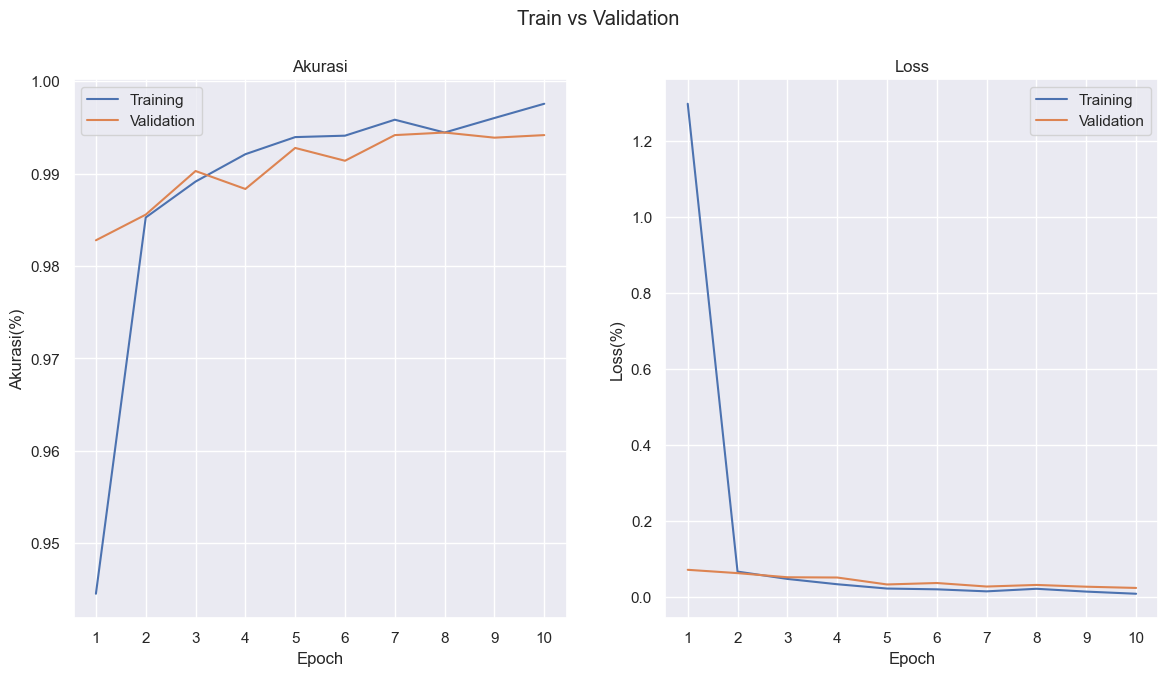

In [28]:
visualisasi_plot(history_rgb)

### Model RGB - Evaluasi Testing

In [29]:
def evaluate_model(model, test_set, hasil_prediksi):
    score = model.evaluate(test_set, verbose=1)
    
    print(
        f"Test Loss     : {score[0]}\
        \nTest Accuracy : {score[1]*100}%"
    )
    
    labels = [label for image, label in test_set.unbatch()]
    
    plt.figure(figsize=(7, 7))
    cm = confusion_matrix(labels, hasil_prediksi)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Negative", "Positive"]
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.grid(False)
    
    plt.show()

32/32 [==============================] - 6s 167ms/step - loss: 0.0127 - accuracy: 0.9967
Test Loss     : 0.012687526643276215        
Test Accuracy : 99.6749997138977%


<Figure size 700x700 with 0 Axes>

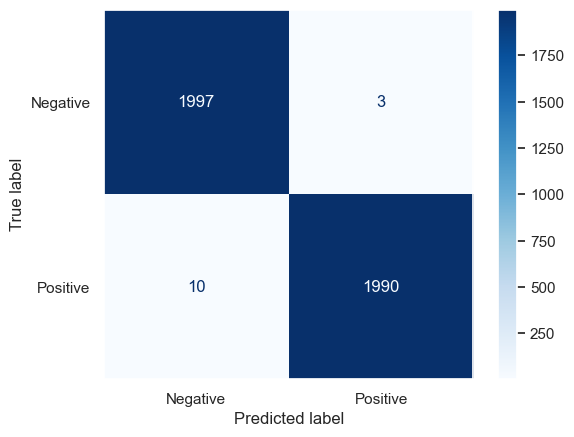

In [31]:
prediksi_rgb = (model_rgb.predict(c_test_rgb).squeeze() >= 0.5).astype(int)

evaluate_model(model_rgb, c_test_rgb, prediksi_rgb)

### Model RGB - Prediksi Test Set

In [32]:
def show_prediction(test_set, hasil_prediksi):

    images = []
    labels = []
    labels_pred = []

    i = 0
    # simpan ke list
    for image, label in test_set.unbatch():
        images.append(image.numpy().astype("uint8"))
        labels.append("Negative" if label == 0 else "Positive")
        labels_pred.append("Negative" if hasil_prediksi[i] == 0 else "Positive")
        i += 1

    plt.figure(figsize=(12, 4))

    # tampilkan 14 gambar prediksi
    for i in range(14):
        plt.subplot(2, 7, i+1)

        # ambil gambar acak
        index = randint(0, len(images))
        plt.imshow(images[index])

        # label prediksi
        color = "green" if labels_pred[index] == labels[index] else "red"
        plt.title(f"{labels_pred[index]}", color=color)

        plt.axis("off")


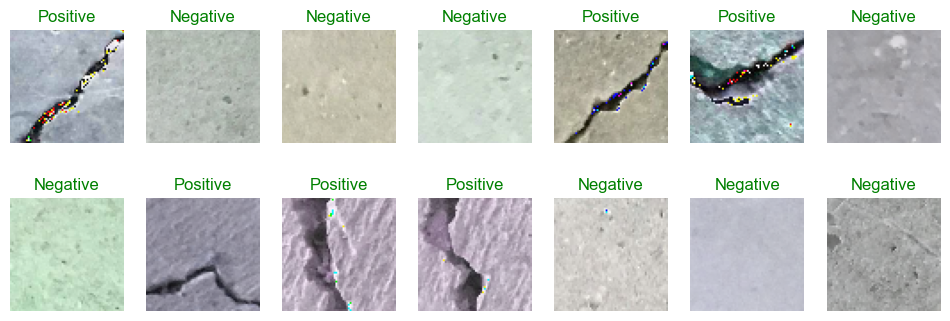

In [33]:
show_prediction(c_test_rgb, prediksi_rgb)

### Model RGB - Kesalahan Prediksi Test Set

In [34]:
def show_mistakes(test_set, hasil_prediksi):
    images = []
    labels = []
    labels_pred = []
    i=0
    
    for image, label in test_set.unbatch():

        # simpan hasil yang salah
        if (label != hasil_prediksi[i]):
            images.append(image.numpy().astype("uint8"))
            labels.append("Negative" if label == 0 else "Positive")
            labels_pred.append("Negative" if hasil_prediksi[i] == 0 else "Positive")
        i+=1

    # tampilkan prediksi yang salah
    plt.figure(figsize=(12, 12))
    i=0
    for i in range(len(images)):
        plt.subplot(7, 7, i+1)
        plt.imshow(images[i])
        plt.title(labels_pred[i], color="red")
        plt.axis("off")
        
    plt.show()
    

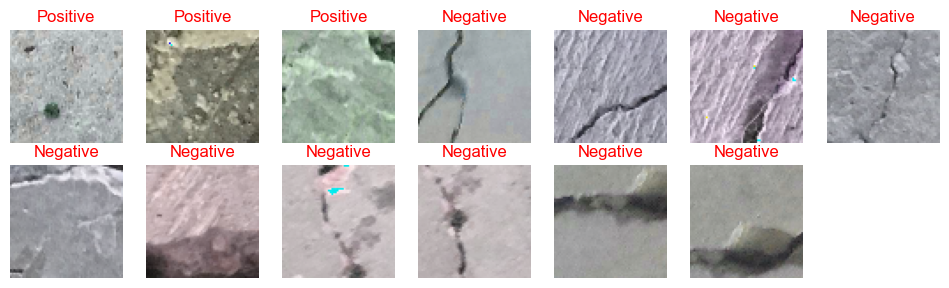

In [35]:
show_mistakes(c_test_rgb, prediksi_rgb)

## B. Model RGB Standardisasi

In [36]:
model_rgb_std = Sequential([
    Input((64, 64, 3)),
    
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_rgb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [37]:
model_rgb_std.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model RGB Standardisasi - Fitting Model

In [38]:
history_rgb_std = model_rgb_std.fit(
    std_train_rgb,
    validation_data=std_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 107s 414ms/step - loss: 0.1325 - accuracy: 0.9471 - val_loss: 0.0839 - val_accuracy: 0.9708
Epoch 2/10
254/254 [==============================] - 102s 400ms/step - loss: 0.0450 - accuracy: 0.9850 - val_loss: 0.0328 - val_accuracy: 0.9892
Epoch 3/10
254/254 [==============================] - 102s 399ms/step - loss: 0.0316 - accuracy: 0.9894 - val_loss: 0.0752 - val_accuracy: 0.9711
Epoch 4/10
254/254 [==============================] - 103s 401ms/step - loss: 0.0285 - accuracy: 0.9907 - val_loss: 0.0173 - val_accuracy: 0.9944
Epoch 5/10
254/254 [==============================] - 103s 401ms/step - loss: 0.0184 - accuracy: 0.9943 - val_loss: 0.0156 - val_accuracy: 0.9956
Epoch 6/10
254/254 [==============================] - 103s 402ms/step - loss: 0.0189 - accuracy: 0.9939 - val_loss: 0.0134 - val_accuracy: 0.9961
Epoch 7/10
254/254 [==============================] - 104s 407ms/step - loss: 0.0131 - accuracy: 0.9963 - val_loss: 0.0141 -

### Model RGB Standardisasi - Visualisasi Training Validation

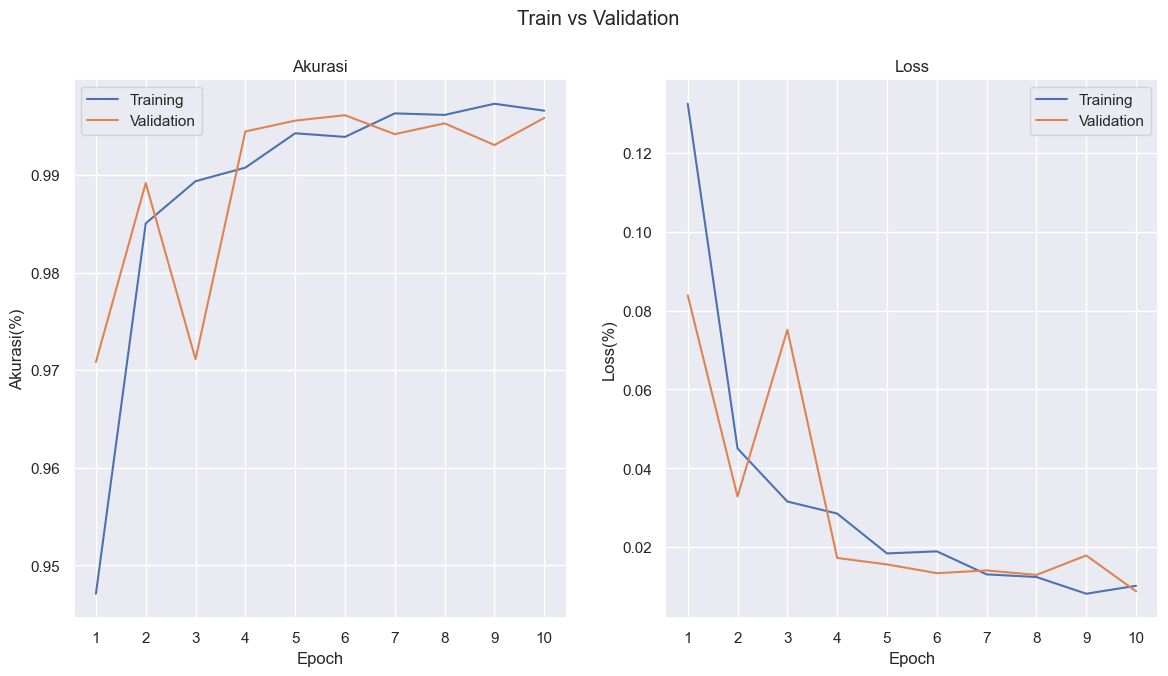

In [39]:
visualisasi_plot(history_rgb_std)

### Model RGB Standardisasi - Evaluasi Testing

32/32 [==============================] - 5s 151ms/step - loss: 0.0266 - accuracy: 0.9933
Test Loss     : 0.026597779244184494        
Test Accuracy : 99.32500123977661%


<Figure size 700x700 with 0 Axes>

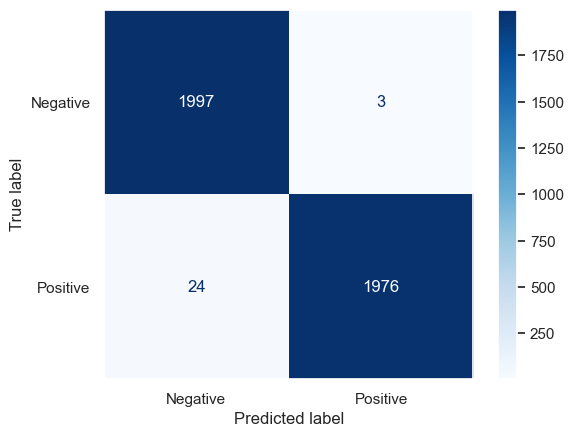

In [40]:
prediksi_rgb_std = (model_rgb_std.predict(std_test_rgb).squeeze() >= 0.5).astype(int)

evaluate_model(model_rgb_std, std_test_rgb, prediksi_rgb_std)

### Model RGB Standardisasi - Prediksi Test Set

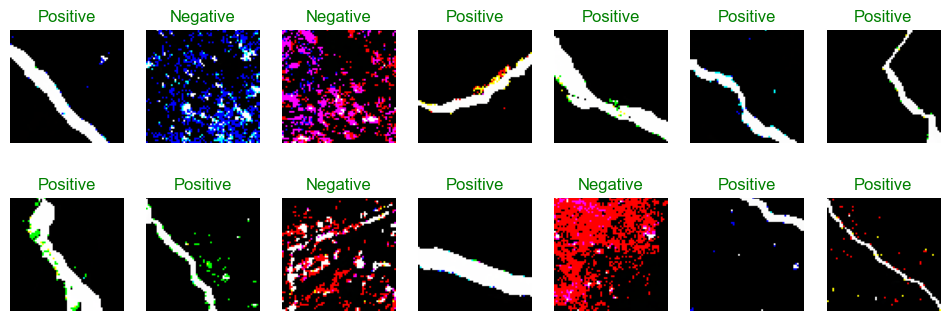

In [41]:
show_prediction(std_test_rgb, prediksi_rgb_std)

### Model RGB Standardisasi - Kesalahan Prediksi Test Set

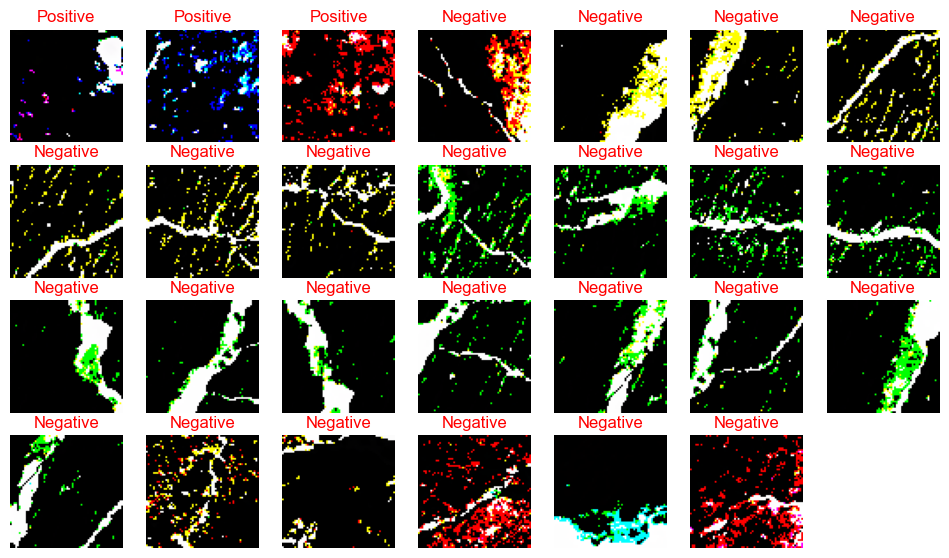

In [42]:
show_mistakes(std_test_rgb, prediksi_rgb_std)

## C. Model Grayscale

In [43]:
model_gray = Sequential([
    Input((64, 64, 1)),

    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),

    Flatten(),
    Dense(1, activation="sigmoid")
])

model_gray.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [44]:
model_gray.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Grayscale - Fitting Model

In [45]:
history_gray = model_gray.fit(
    c_train_gray,
    validation_data=c_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 85s 327ms/step - loss: 0.2594 - accuracy: 0.9611 - val_loss: 0.0398 - val_accuracy: 0.9889
Epoch 2/10
254/254 [==============================] - 76s 298ms/step - loss: 0.0359 - accuracy: 0.9895 - val_loss: 0.0292 - val_accuracy: 0.9925
Epoch 3/10
254/254 [==============================] - 77s 300ms/step - loss: 0.0226 - accuracy: 0.9929 - val_loss: 0.0204 - val_accuracy: 0.9939
Epoch 4/10
254/254 [==============================] - 82s 320ms/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 0.0246 - val_accuracy: 0.9919
Epoch 5/10
254/254 [==============================] - 77s 301ms/step - loss: 0.0217 - accuracy: 0.9938 - val_loss: 0.0313 - val_accuracy: 0.9908
Epoch 6/10
254/254 [==============================] - 81s 314ms/step - loss: 0.0120 - accuracy: 0.9967 - val_loss: 0.0160 - val_accuracy: 0.9956
Epoch 7/10
254/254 [==============================] - 83s 323ms/step - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.0180 - val_ac

### Model Grayscale - Visualisasi Training Validation

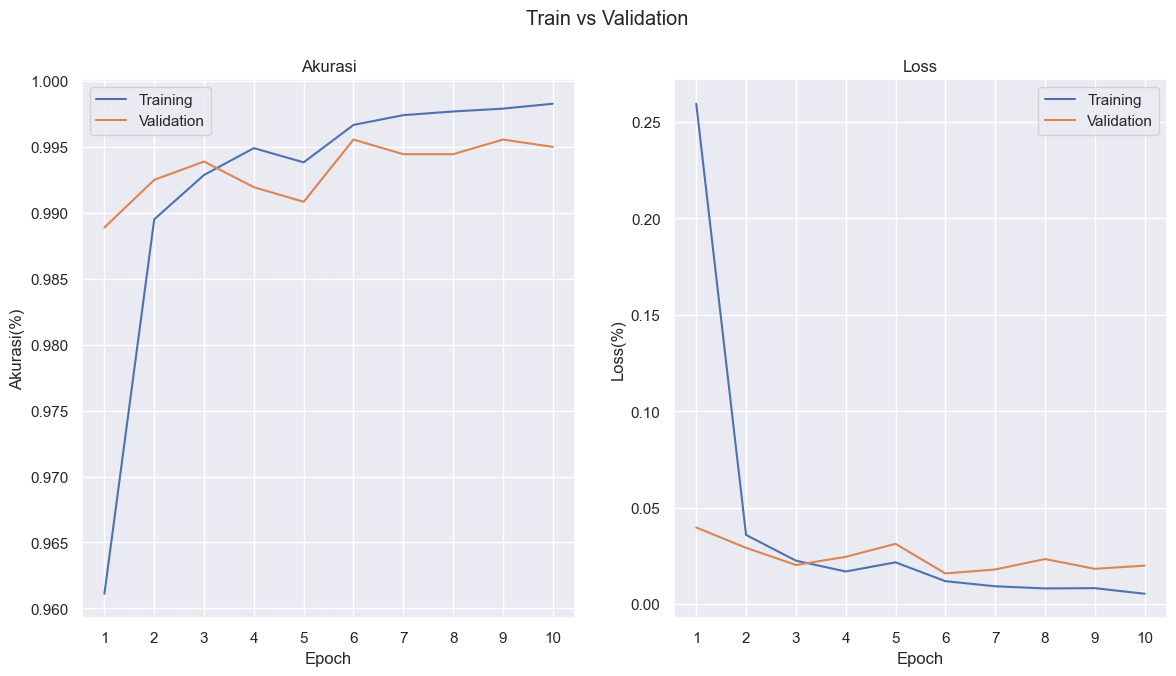

In [46]:
visualisasi_plot(history_gray)

### Model Grayscale - Evaluasi Testing

32/32 [==============================] - 4s 132ms/step - loss: 0.0086 - accuracy: 0.9985
Test Loss     : 0.008560487069189548        
Test Accuracy : 99.84999895095825%


<Figure size 700x700 with 0 Axes>

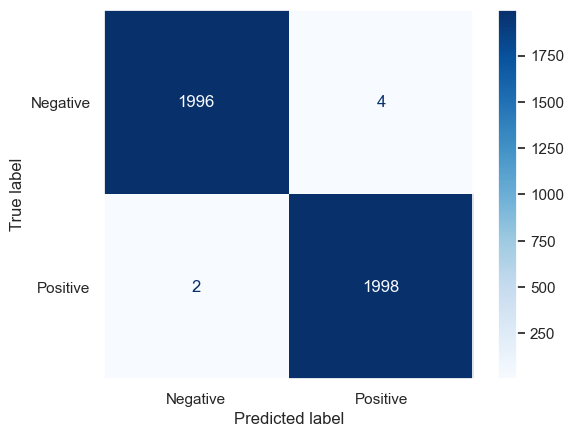

In [47]:
prediksi_gray = (model_gray.predict(c_test_gray).squeeze() >= 0.5).astype(int)

evaluate_model(model_gray, c_test_gray, prediksi_gray)

### Model Grayscale - Prediksi Test Set

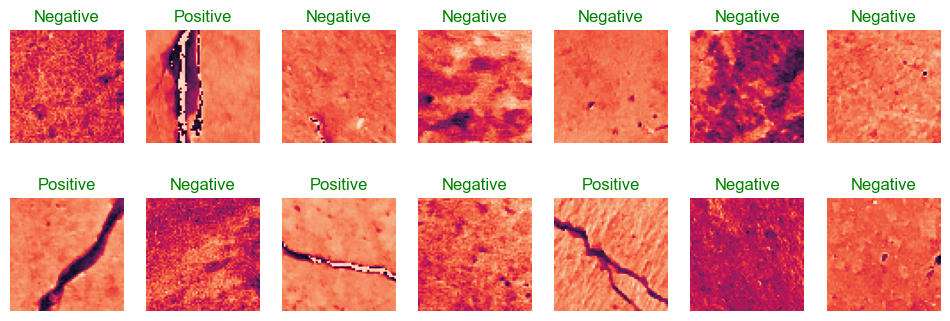

In [48]:
show_prediction(c_test_gray, prediksi_gray)

### Model Grayscale - Kesalahan Prediksi Test Set

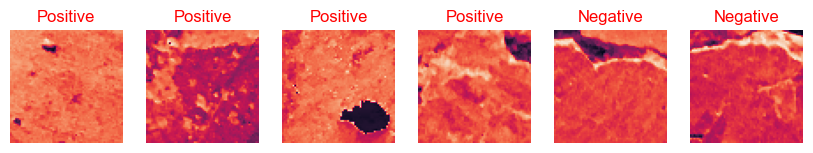

In [49]:
show_mistakes(c_test_gray, prediksi_gray)

## D. Model Grayscale Standardisasi

In [50]:
model_gray_std = Sequential([
    Input((64, 64, 1)),

    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),

    Flatten(),
    Dense(1, activation="sigmoid")
])

model_gray.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [51]:
model_gray_std.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Grayscale Standardisasi - Fitting Model

In [52]:
history_gray_std = model_gray_std.fit(
    std_train_gray,
    validation_data = std_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 89s 341ms/step - loss: 0.1408 - accuracy: 0.9467 - val_loss: 0.0541 - val_accuracy: 0.9811
Epoch 2/10
254/254 [==============================] - 86s 334ms/step - loss: 0.0561 - accuracy: 0.9813 - val_loss: 0.0492 - val_accuracy: 0.9831
Epoch 3/10
254/254 [==============================] - 86s 335ms/step - loss: 0.0443 - accuracy: 0.9852 - val_loss: 0.0399 - val_accuracy: 0.9861
Epoch 4/10
254/254 [==============================] - 79s 308ms/step - loss: 0.0355 - accuracy: 0.9882 - val_loss: 0.0277 - val_accuracy: 0.9903
Epoch 5/10
254/254 [==============================] - 85s 331ms/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.0217 - val_accuracy: 0.9925
Epoch 6/10
254/254 [==============================] - 79s 308ms/step - loss: 0.0207 - accuracy: 0.9935 - val_loss: 0.0298 - val_accuracy: 0.9892
Epoch 7/10
254/254 [==============================] - 79s 307ms/step - loss: 0.0184 - accuracy: 0.9935 - val_loss: 0.0360 - val_ac

### Model Grayscale Standardisasi - Visualisasi Training Validation

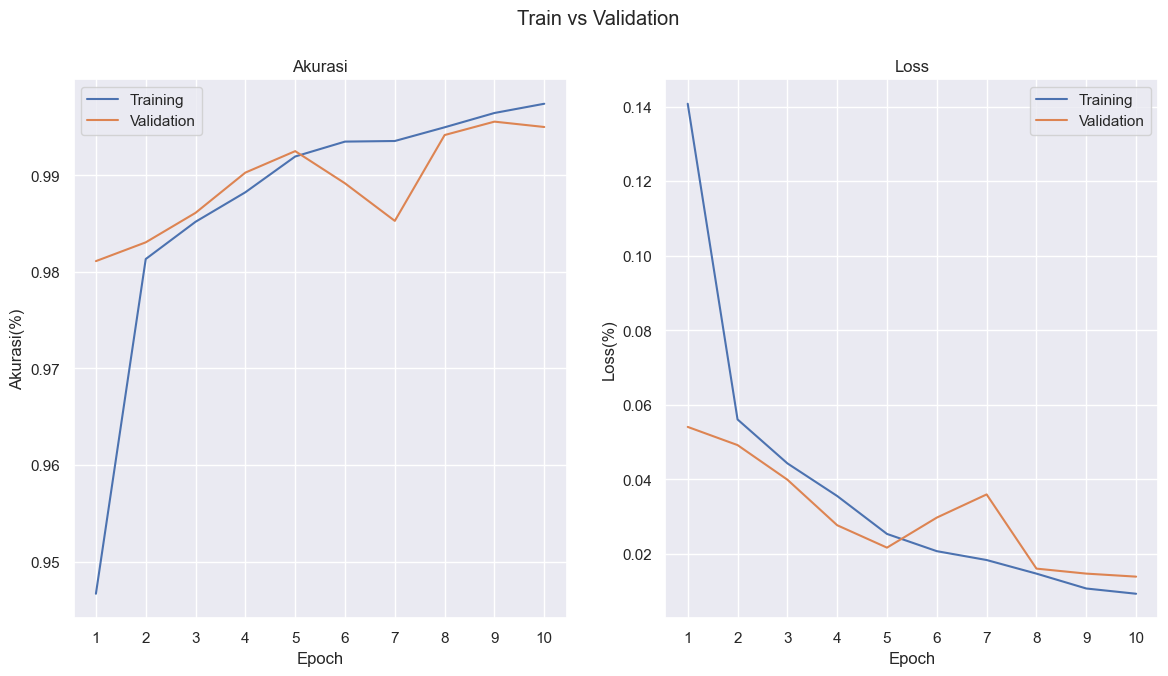

In [53]:
visualisasi_plot(history_gray_std)

### Model Grayscale Standardisasi - Evaluasi Testing

32/32 [==============================] - 5s 134ms/step - loss: 0.0293 - accuracy: 0.9900
Test Loss     : 0.029298346489667892        
Test Accuracy : 99.00000095367432%


<Figure size 700x700 with 0 Axes>

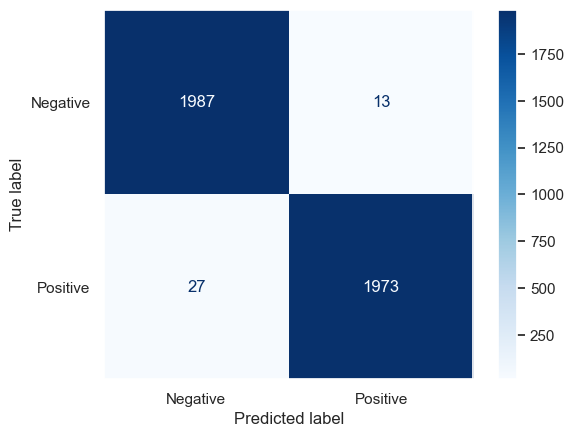

In [54]:
prediksi_gray_std = (model_gray_std.predict(std_test_gray).squeeze() >= 0.5).astype(int)

evaluate_model(model_gray_std, std_test_gray, prediksi_gray_std)

### Model Grayscale Standardisasi - Prediksi Test Set

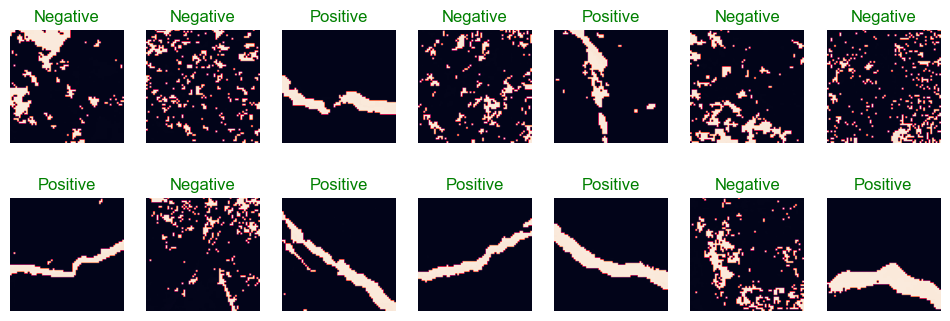

In [55]:
show_prediction(std_test_gray, prediksi_gray_std)

### Model Grayscale Standardisasi - Kesalahan Prediksi Test Set

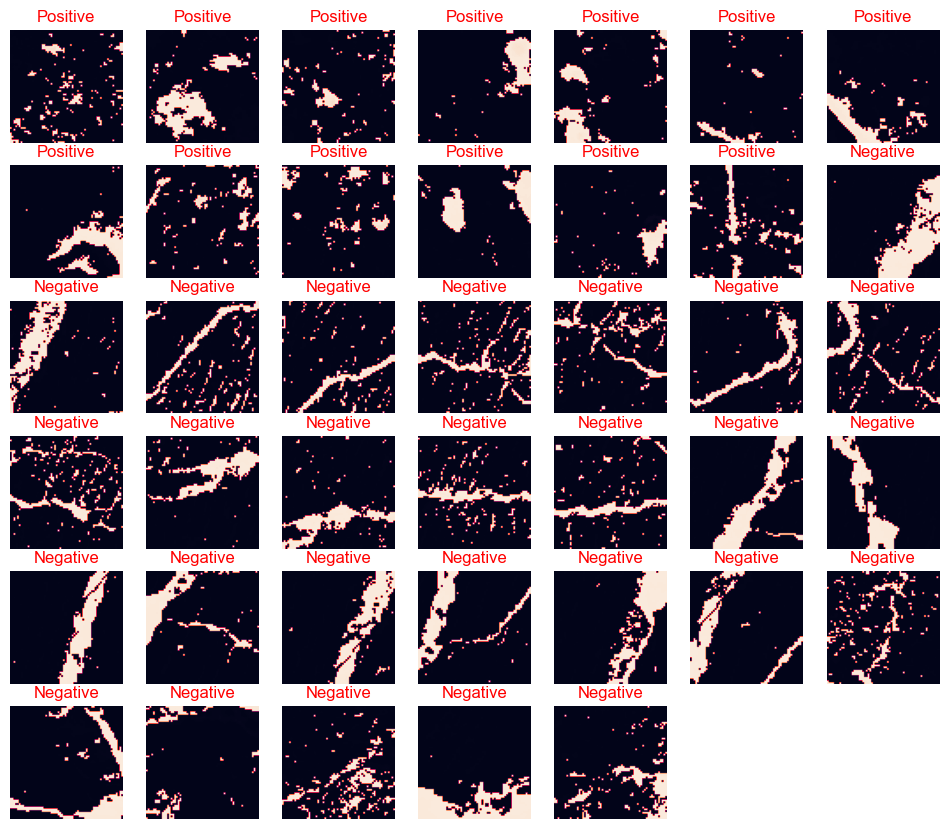

In [56]:
show_mistakes(std_test_gray, prediksi_gray_std)